In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_dir = 'times'
hosts = ['macbook']
sizes = ['small', 'medium']
benchmarks = ['full', 'partial', 'no', 'metadata']
benchmarks_labels = ['Full restore', 'Partial restore', 'No restore', 'Metadata only']
legacies = ['true', 'false']

runs = dict()
for host in hosts:
    runs[host] = dict()
    for size in sizes:
        runs[host][size] = dict()
        for benchmark in benchmarks:
            runs[host][size][benchmark] = dict()
            for legacy in legacies:
                with open(f'{base_dir}/{host}_{size}_{benchmark}_{legacy}.csv', 'r') as f:
                    lines = np.array([float(line.strip()) for line in f.readlines()])
                    runs[host][size][benchmark][legacy] = lines

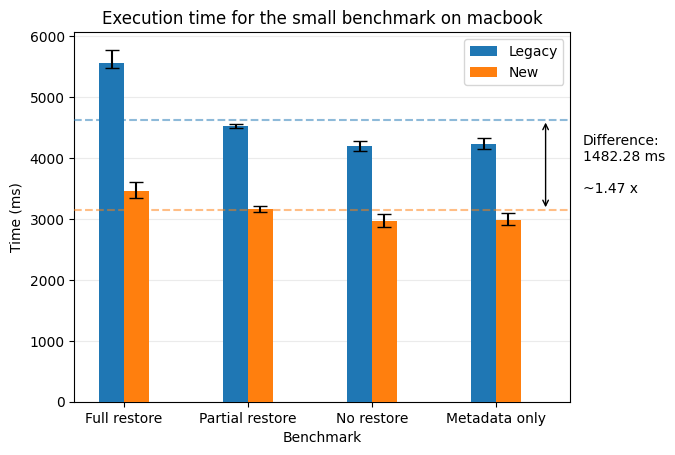

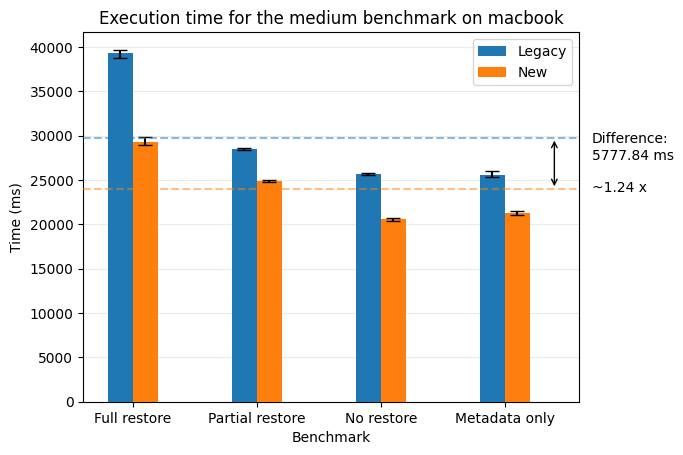

In [3]:
def clean(times):
    no_outliers = np.sort(times)[1:-1]
    return np.mean(no_outliers), np.min(no_outliers), np.max(no_outliers)

def plot_bars(runs, host, size):
    width = .2
    off = -width
    super_means = []
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for l in legacies:
        means = []
        mins = []
        maxs = []
        for b in benchmarks:
            mean, mi, ma = clean(runs[host][size][b][l])
            means.append(mean)
            mins.append(mi)
            maxs.append(ma)

        super_means.append(np.mean(means))
        means = np.array(means)
        mins = np.array(mins)
        maxs = np.array(maxs)

        plt.bar(np.arange(len(benchmarks)) + off, means, yerr=[means-mins, maxs-means], capsize=5, width=.2, label='Legacy' if l == 'true' else 'New', zorder=3)
        off += width
    plt.legend()

    plt.hlines(super_means[0], -.5, len(benchmarks)-.5, colors=colors[0], alpha=.5, linestyles='dashed', label='Legacy mean', zorder=4)
    plt.hlines(super_means[1], -.5, len(benchmarks)-.5, colors=colors[1], alpha=.5, linestyles='dashed', label='New mean', zorder=4)

    # Highlight the difference between the two means
    plt.annotate('', xy=(3.3, super_means[1]), xytext=(3.3, super_means[0]), arrowprops=dict(arrowstyle='<->', color='black'))
    plt.text(3.6, (super_means[0]+super_means[1])/2, f'Difference:\n{np.abs(super_means[1]-super_means[0]):.2f} ms\n\n~{super_means[0]/super_means[1]:.2f} x', verticalalignment='center', horizontalalignment='left')

    plt.xticks(np.arange(len(benchmarks))-.5*width, benchmarks_labels)
    plt.xlim(-.5, len(benchmarks)-.5)
    plt.ylabel('Time (ms)')
    plt.xlabel('Benchmark')
    plt.title(f'Execution time for the {size} benchmark on {host}')
    plt.grid(axis='y', alpha=.25, zorder=0)

plot_bars(runs, hosts[0], 'small')
plt.show()
plot_bars(runs, hosts[0], 'medium')
plt.show()